 ## Wrangle and Analyze Twitter Data
 
 Goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. 
 
 The Twitter archive contains very basic tweet information. Additional gathering, then assessing and cleaning is required for analyses and visualizations.

Three datasets:

- Twitter_archive_enhanced.csv
- Image_predictions.tsv
    - using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
- Get tweet retweet count, and ‘like’ count from Twitter API, tweet_json.txt
    - Using Tweepy library, https://www.tweepy.org/ 


**Project Steps Overview**

Step 1: Gathering data

Step 2: Assessing data

Step 3: Cleaning data

Step 4: Storing data

Step 5: Analyzing, and visualizing data

Step 6: Reporting
- data wrangling efforts
- data analyses and visualizations



**Assumptions:**


- Retrievers are the most popular dog breed
- Puppers best the best rated dogs
- iphones are the most use source

Packages

In [30]:
# load necessary libraries
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import tweepy
import json
%run config


<h3><span style="color:orange"><em>Gather Data</em></span></h3>

**CSV File** - archieved Tweets

In [31]:
# get csv data, first look at data
df1=pd.read_csv('twitter-archive-enhanced.csv')
df1.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1216,714982300363173890,NaN,NaN,2016-03-30 01:07:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Calbert. He forgot to clear his Google...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714982300...,9,10,Calbert,None,None,None,None
999,748220828303695873,NaN,NaN,2016-06-29 18:25:21 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Stop what you're doing and watch this heckin m...,NaN,NaN,NaN,https://vine.co/v/iiLjKuYJpr6,13,10,None,None,None,None,None
1660,683078886620553216,NaN,NaN,2016-01-02 00:14:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we see a nifty leaping pupper. Feet look ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683078886...,9,10,None,None,None,pupper,None
562,802600418706604034,NaN,NaN,2016-11-26 19:50:26 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Bailey. She has mastered the head tilt...,NaN,NaN,NaN,https://vine.co/v/5FwUWjYaW0Y,11,10,Bailey,None,None,None,None
2008,672256522047614977,NaN,NaN,2015-12-03 03:30:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Mighty rare dogs here. Long smooth necks. Grea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672256522...,8,10,None,None,None,None,None


**TSV File** - image predictions file

In [32]:
# get image predictions data, first look
try:
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    df2=pd.read_csv(url, sep='\t')
except:
    print("A problem occured with your link")

In [33]:
df2.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
809,692158366030913536,https://pbs.twimg.com/media/CZsKVxfWQAAXy2u.jpg,1,pug,0.956565,True,swing,0.018907,False,toy_poodle,0.013544,True
1658,810984652412424192,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True
1645,808134635716833280,https://pbs.twimg.com/media/Cx5R8wPVEAALa9r.jpg,1,cocker_spaniel,0.740220,True,Dandie_Dinmont,0.061604,True,English_setter,0.041331,True
446,674664755118911488,https://pbs.twimg.com/media/CVzkA7-WsAAcXz6.jpg,1,African_crocodile,0.330625,False,American_alligator,0.075356,False,mink,0.057481,False
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


**Twitter Data** - Twitter API tweets data

In [34]:
# Create an API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Get Twitter API data

In [35]:
# Fetch tweets from the twitter API using a loop
tweets = []
# list of Tweet Ids not found
ids_with_no_tweets = []

for tweet_id in df1['tweet_id']:   
    try:
        tweets.append(api.get_status(tweet_id, tweet_mode='extended'))
    except:
        ids_with_no_tweets.append(tweet_id)

Rate limit reached. Sleeping for: 742
Rate limit reached. Sleeping for: 742


Store Twitter API data

In [36]:
# Create a list of dictionaries
list_of_dicts = []
for each_json_tweet in tweets:
    list_of_dicts.append(each_json_tweet._json)
    
#Write list of dictionaries into a txt file
with open('tweets.txt', 'w') as f:
        f.write(json.dumps(list_of_dicts, indent=4))

In [37]:
# Dictionary to Dataframe
df3=pd.read_json('tweets.txt')

In [38]:
df3.sample(10)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
285,2017-02-28 18:46:45+00:00,836648853927522308,836648853927522304,RT @SchafeBacon2016: @dog_rates Slightly distu...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Tue Feb 28 18:43:57 +0000 2017...,NaN,NaN,NaN,NaN
262,2017-03-11 01:15:58+00:00,840370681858686976,840370681858686976,You have been visited by the magical sugar jar...,False,"[0, 113]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 840370672886923264, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
948,2016-07-04 17:00:26+00:00,750011400160841729,750011400160841728,Meet Piper. She's an airport doggo. Please ret...,False,"[0, 113]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 749821559804690432, 'id_str'...","<a href=""https://about.twitter.com/products/tw...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
905,2016-07-14 02:47:04+00:00,753420520834629632,753420520834629632,Here we are witnessing an isolated squad of bo...,False,"[0, 115]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 753420390836346880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
72,2017-06-24 00:09:53+00:00,878404777348136964,878404777348136960,RT @dog_rates: Meet Shadow. In an attempt to r...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Fri Jun 23 16:00:04 +0000 2017...,NaN,NaN,NaN,NaN
568,2016-11-17 17:50:33+00:00,799308762079035393,799308762079035392,RT @dog_rates: I WAS SENT THE ACTUAL DOG IN TH...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Fri Sep 09 18:31:54 +0000 2016...,NaN,NaN,NaN,NaN
1522,2016-01-18 17:52:38+00:00,689143371370250240,689143371370250240,Meet Trip. He likes wearing costumes that aren...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 689143357063475200, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
687,2016-10-09 23:44:41+00:00,785264754247995392,785264754247995392,This is Doc. He requested to be carried around...,False,"[0, 80]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 785264731401646082, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
21,2017-07-19 03:39:09+00:00,887517139158093824,887517139158093824,I've yet to rate a Venezuelan Hover Wiener. Th...,False,"[0, 108]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 887517108413886465, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1869,2015-12-09 19:22:56+00:00,674670581682434048,674670581682434048,Meet Jeb &amp; Bush. Jeb is somehow stuck in t...,False,"[0, 143]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 674670575701348352, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [39]:
# Get desired data, check dataframe
#df3=df3[['created_at', 'id', 'favorited', 'retweeted']]
#df3.sample(5)

<h3><span style="color:orange"><em>Assess Data</em></span></h3>

Detect and document at least eight (8) quality issues and two (2) tidiness issues.

The following issues must be assessed.

- Only original ratings (no retweets) that have images. 
    - There are 5000+ tweets in the dataset 
    - Not all are dog ratings and some are retweets
- Assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
- The rating numerators are greater than the denominators does not need to be cleaned. 
    - This unique rating system is a big part of the popularity of WeRateDogs.
- Do not gather the tweets beyond August 1st, 2017. 


<h5><span style="color:#214AF6"><em>CSV file - archieved tweets</em></span></h5>

Visual assessment

In [40]:
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [41]:
df1.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [42]:
df1.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1451,695794761660297217,NaN,NaN,2016-02-06 02:22:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wyatt. His throne is modeled after him...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695794761...,13,10,Wyatt,None,None,None,None
2013,672231046314901505,NaN,NaN,2015-12-03 01:49:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Exotic underwater dog here. Very shy. Wont ret...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672231046...,5,10,None,None,None,None,None
1746,679132435750195208,NaN,NaN,2015-12-22 02:52:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Louis. He's a river dancer. His friend...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679132435...,10,10,Louis,None,None,None,None
1773,678255464182861824,NaN,NaN,2015-12-19 16:47:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jessifer. She is a Bismoth Teriyaki. F...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678255464...,9,10,Jessifer,None,None,None,None
1212,715342466308784130,NaN,NaN,2016-03-31 00:58:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oscar. He's a world renowned snowball ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715342466...,10,10,Oscar,None,None,None,None


Programmatic assessment

In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [44]:
df1[df1.duplicated()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [45]:
df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


**df1( archieved tweets) Column Quality Issues**
- in_reply_to_status missing records
- in_reply_to_user_id missing records
- retweeted_status_id missing records
- retweeted_status_user_id missing records
- retweeted_status_timestamp missing records
- expanded_urls missing records
- source hrf=, html used with url
- timestamp string not date
- extract source out of html code in source column

**df1( archieved tweets) Column Tidyness Issues**
- missing column for rating: numerator/denominator
- some numerators/denominators are huge
- zero denominator

<h5><span style="color:#214AF6"><em>TSV file - image predictions</em></span></h5>

Visual assessment

In [46]:
# check enties for a tweet id
df2[df2['tweet_id']==889531135344209921]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2060,889531135344209921,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1,golden_retriever,0.953442,True,Labrador_retriever,0.013834,True,redbone,0.007958,True


In [47]:
# view top of df
df2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [48]:
# view end of df
df2.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [49]:
# get random sample
df2.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1528,789137962068021249,https://pbs.twimg.com/media/CvOUw8vWYAAzJDq.jpg,2,Chihuahua,0.746135,True,Pekinese,0.070383,True,Pembroke,0.049237,True
1359,760893934457552897,https://pbs.twimg.com/media/Co88_ujWEAErCg7.jpg,1,Blenheim_spaniel,0.113992,True,cocker_spaniel,0.105780,True,borzoi,0.073935,True
2058,888917238123831296,https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg,1,golden_retriever,0.714719,True,Tibetan_mastiff,0.120184,True,Labrador_retriever,0.105506,True
1886,847962785489326080,https://pbs.twimg.com/media/C8SRpHNUIAARB3j.jpg,1,sea_lion,0.882654,False,mink,0.066880,False,otter,0.025679,False
1399,768596291618299904,https://pbs.twimg.com/media/CqqaPjqWIAAOyNL.jpg,1,Great_Pyrenees,0.729745,True,golden_retriever,0.237961,True,Labrador_retriever,0.020903,True


Programmatic assessment

In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [51]:
df2[df2.duplicated()==True]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


df2(image prediction) Column Quality Issues
- p1 data naming convention inconsistent
- p2 data naming convention inconsistent
- p3 data naming convention inconsistent

<h5><span style="color:#214AF6"><em>JSON file - twitter API</em></span></h5>

Visual Assessment

In [52]:
df3.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [53]:
df3.tail()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
2321,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2322,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2323,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2324,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2325,2015-11-15 22:32:08+00:00,666020888022790149,666020888022790144,Here we have a Japanese Irish Setter. Lost eye...,False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666020881337073664, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [54]:
df3.sample(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
730,2016-09-22 16:13:51+00:00,778990705243029504,778990705243029504,This is Jay. He's really h*ckin happy about th...,False,"[0, 110]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 778990686406402048, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1156,2016-04-09 01:35:37+00:00,718613305783398402,718613305783398400,This is Carper. He's a Tortellini Angiosperm. ...,False,"[0, 124]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 718613299022180352, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1387,2016-02-13 22:29:29+00:00,698635131305795584,698635131305795584,Here we are witnessing five Guatemalan Birch F...,False,"[0, 134]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 698635005506015234, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
16,2017-07-23 00:22:39+00:00,888917238123831296,888917238123831296,This is Jim. He found a fren. Taught him how t...,False,"[0, 86]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 888917229776945152, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1413,2016-02-08 17:58:03+00:00,696754882863349760,696754882863349760,This is Reptar. He specifically asked for his ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 696754874445230081, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


Programmatic assessment

In [55]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2326 non-null   datetime64[ns, UTC]
 1   id                             2326 non-null   int64              
 2   id_str                         2326 non-null   int64              
 3   full_text                      2326 non-null   object             
 4   truncated                      2326 non-null   bool               
 5   display_text_range             2326 non-null   object             
 6   entities                       2326 non-null   object             
 7   extended_entities              2056 non-null   object             
 8   source                         2326 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

**df3( API tweet data) column Quality Issues**
- Many unwanted columns
    - Desired columns: ['created_at', 'id', 'favorited', 'retweeted']

<h2><span style="color:orange"><em>Cleaning Data</em></span></h2>

Clean all of the issues documented while assessing. 


- Make a copy of each piece of data.

- Use the define-code-test framework and clearly document it.

- Cleaning includes merging individual pieces of data according to the rules of tidy data. 

- The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

<h5><span style="color:#214AF6"><em>CSV file - archieved tweets</em></span></h5>

**df1( archieved tweets) Column Quality Issues**
- in_reply_to_status missing records
- in_reply_to_user_id missing records
- retweeted_status_id missing records
- retweeted_status_user_id missing records
- retweeted_status_timestamp missing records
- expanded_urls missing records, messy values
- source hrf=, html used with url
    - extract source out of html code in 'source' column
- timestamp string not date


**df1( archieved tweets) Column Tidyness Issues**
- missing column for rating: numerator/denominator

In [56]:
# Make a copy
df1_clean=df1.copy()

**DEFINE**

- delete columns due to overwhelming amounts of missing data and unwanted data for analysis
    - in_reply_to_status missing records
    - in_reply_to_user_id missing records
    - retweeted_status_id missing records
    - retweeted_status_user_id missing records
    - retweeted_status_timestamp missing records

**CODE**

In [57]:
# drop columns
df1_clean=df1_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

**TEST**

In [58]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


**DEFINE**

- fix rows with missing data
    - expanded_urls missing records

The 'expanded_urls' column is a link to dog pictures posted per tweet id. If there is no expanded_url, there was no picture posted. 

We Rate Dogs rates dogs by picture so the rows with missing photos will be dropped.

In [59]:
df1_clean['expanded_urls'][0]

'https://twitter.com/dog_rates/status/892420643555336193/photo/1'

In [60]:
df1_clean['expanded_urls'][309]

'https://www.gofundme.com/lolas-life-saving-surgery-funds,https://twitter.com/dog_rates/status/835264098648616962/photo/1,https://twitter.com/dog_rates/status/835264098648616962/photo/1'

**CODE**

In [61]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


In [62]:
# save tweet_id that will be dropped for later confirmation of no photo
no_photo=(df1_clean[df1_clean['expanded_urls'].isnull()].tweet_id).to_list()

In [63]:
df1_clean=df1_clean.dropna()

**TEST**

In [64]:
# checking they were dropped
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2297 non-null   int64 
 1   timestamp           2297 non-null   object
 2   source              2297 non-null   object
 3   text                2297 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2297 non-null   int64 
 6   rating_denominator  2297 non-null   int64 
 7   name                2297 non-null   object
 8   doggo               2297 non-null   object
 9   floofer             2297 non-null   object
 10  pupper              2297 non-null   object
 11  puppo               2297 non-null   object
dtypes: int64(3), object(9)
memory usage: 233.3+ KB


In [65]:
df1_clean.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2013,672231046314901505,2015-12-03 01:49:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Exotic underwater dog here. Very shy. Wont ret...,https://twitter.com/dog_rates/status/672231046...,5,10,None,None,None,None,None
1012,747242308580548608,2016-06-27 01:37:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This pupper killed this great w...,https://twitter.com/dog_rates/status/704761120...,13,10,None,None,None,pupper,None
1561,688385280030670848,2016-01-16 15:40:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Louis. He's takes top-notch selfies. 1...,https://twitter.com/dog_rates/status/688385280...,12,10,Louis,None,None,None,None


**DEFINE**

- source hrf=, html used with url
    - extract source out of html code in 'source' column

In [66]:
# view the unique source types
df1_clean['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

**SOURCE**

1 - tweetdeck

2 - vine.co

3 - twitter.com

4 - iphone

In [67]:
# find and replace source categories with
numeric_var = {'source': {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':4, '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':3, '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':2, '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':1}}
df1_clean = df1_clean.replace(numeric_var)

**TEST**

In [68]:
df1_clean.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
356,830583320585068544,2017-02-12 01:04:29 +0000,4,This is Lilly. She just parallel barked. Kindl...,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
1909,674422304705744896,2015-12-09 02:56:22 +0000,4,This is Ava. She doesn't understand flowers. 1...,https://twitter.com/dog_rates/status/674422304...,12,10,Ava,None,None,None,None
1803,676948236477857792,2015-12-16 02:13:31 +0000,4,This is Karl. Karl thinks he's slick. 6/10 sne...,https://twitter.com/dog_rates/status/676948236...,6,10,Karl,None,None,None,None


**DEFINE**

- timestamp string not date
    - convert timestamp from str to datetime

In [69]:
df1_clean['timestamp'][2]

'2017-07-31 00:18:03 +0000'

**CODE**

In [70]:
# change timestamp to datetime
df1_clean['timestamp']=pd.to_datetime(df1_clean['timestamp'])

**TEST**

In [71]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2297 non-null   int64              
 1   timestamp           2297 non-null   datetime64[ns, UTC]
 2   source              2297 non-null   int64              
 3   text                2297 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2297 non-null   int64              
 6   rating_denominator  2297 non-null   int64              
 7   name                2297 non-null   object             
 8   doggo               2297 non-null   object             
 9   floofer             2297 non-null   object             
 10  pupper              2297 non-null   object             
 11  puppo               2297 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(4

In [72]:
df1_clean['timestamp'][4]

Timestamp('2017-07-29 16:00:24+0000', tz='UTC')

**DEFINE**

- missing column for rating: numerator/denominator
    - check for extreme values
    - check for zero denominators, change to 10

In [73]:
# chack numerator values
df1_clean[['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10
...,...,...
2351,5,10
2352,6,10
2353,9,10
2354,7,10


In [74]:
# check denominator values
df1_clean['rating_denominator'].value_counts()

10     2278
11        3
50        3
80        2
70        1
7         1
150       1
170       1
20        1
90        1
40        1
130       1
110       1
120       1
2         1
Name: rating_denominator, dtype: int64

As stated in WeRateDogs: 'WeRateDogs asks people to send photos of their dogs, then tweets selected photos rating and a humorous comment. Dogs are rated on a scale of one to ten, but are invariably given ratings in excess of the maximum, such as "13/10"'

The denominator should be 10. Without knowing Twitter user's intentions on the rating denominator and since most denominators are 10, I will drop all denominators not 10.

**CODE**

In [75]:
# keep only rows with rating_denominator is 10
df1_clean=df1_clean.loc[df1_clean['rating_denominator']==10]

**TEST**

In [76]:
# get all unique values of denominator rating
df1_clean['rating_denominator'].unique()

array([10], dtype=int64)

In [77]:
# create a rating column, rating_numerator/rating_denominator
df1_clean['rating']=df1_clean['rating_numerator']/df1_clean['rating_denominator']

In [78]:
df1_clean.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
378,827933404142436356,2017-02-04 17:34:40+00:00,4,This is Kona. Yesterday she stopped by the dep...,https://twitter.com/dog_rates/status/827933404...,12,10,Kona,None,None,pupper,None,1.2
1078,739485634323156992,2016-06-05 15:54:48+00:00,4,This is Kyle. He's a heavy drinker and an avid...,https://twitter.com/dog_rates/status/739485634...,6,10,Kyle,None,None,None,None,0.6
1971,673270968295534593,2015-12-05 22:41:22+00:00,4,This is Mac. His dad's probably a lawyer. 11/1...,https://twitter.com/dog_rates/status/673270968...,11,10,Mac,None,None,None,None,1.1


In [79]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2278 non-null   int64              
 1   timestamp           2278 non-null   datetime64[ns, UTC]
 2   source              2278 non-null   int64              
 3   text                2278 non-null   object             
 4   expanded_urls       2278 non-null   object             
 5   rating_numerator    2278 non-null   int64              
 6   rating_denominator  2278 non-null   int64              
 7   name                2278 non-null   object             
 8   doggo               2278 non-null   object             
 9   floofer             2278 non-null   object             
 10  pupper              2278 non-null   object             
 11  puppo               2278 non-null   object             
 12  rating              2278 non-null 

<h5><span style="color:#214AF6"><em>TSV file - image predictions</em></span></h5>

df2(image prediction) Column Quality Issues
- p1 data naming convention inconsistent
- p2 data naming convention inconsistent
- p3 data naming convention inconsistent

In [80]:
# Make a copy
df2_clean=df2.copy()

**DEFINE**

p1, p2, p3 naming conventions are inconsistant. Change all letters to lowercase.

In [81]:
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [82]:
df2_clean.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1937,860276583193509888,https://pbs.twimg.com/media/C_BQ_NlVwAAgYGD.jpg,1,lakeside,0.312299,False,dock,0.159842,False,canoe,0.070794,False
931,703079050210877440,https://pbs.twimg.com/media/CcHWqQCW8AEb0ZH.jpg,2,Pembroke,0.778503,True,Shetland_sheepdog,0.093834,True,Cardigan,0.060296,True
52,666996132027977728,https://pbs.twimg.com/media/CUGlb6iUwAITEbW.jpg,1,hay,0.507637,False,Rottweiler,0.062490,True,water_buffalo,0.048425,False


**CODE**

In [83]:
# change string to lowercase
df2_clean['p1']= df2_clean['p1'].str.lower()
df2_clean['p2']= df2_clean['p2'].str.lower()
df2_clean['p3']= df2_clean['p3'].str.lower()

**TEST**

In [84]:
df2_clean['p1'].unique()

array(['welsh_springer_spaniel', 'redbone', 'german_shepherd',
       'rhodesian_ridgeback', 'miniature_pinscher',
       'bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'gordon_setter',
       'walker_hound', 'pug', 'bloodhound', 'lhasa', 'english_setter',
       'hen', 'desktop_computer', 'italian_greyhound', 'maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'blenheim_spaniel', 'pembroke', 'llama',
       'chesapeake_bay_retriever', 'curly-coated_retriever', 'dalmatian',
       'ibizan_hound', 'border_collie', 'labrador_retriever', 'seat_belt',
       'snail', 'miniature_schnauzer', 'airedale', 'triceratops', 'swab',
       'hay', 'hyena', 'jigsaw_puzzle', 'west_highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'rottweiler',
       'siberian_husky', 't

In [85]:
df2_clean['p2'].unique()

array(['collie', 'miniature_pinscher', 'malinois', 'redbone',
       'rottweiler', 'english_springer', 'mud_turtle', 'tibetan_mastiff',
       'shopping_basket', 'komondor', 'yorkshire_terrier',
       'english_foxhound', 'bull_mastiff', 'german_shepherd', 'shih-tzu',
       'newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'chesapeake_bay_retriever', 'siberian_husky', 'skunk',
       'afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow', 'irish_terrier', 'chain_saw', 'beagle',
       'giant_schnauzer', 'labrador_retriever', 'pembroke', 'chihuahua',
       'weimaraner', 'slug', 'brittany_spaniel', 'standard_schnauzer',
       'teddy', 'armadillo', 'african_hunting_dog', 'vizsla', 'doormat',
       'pug', 'italian_greyhound', 'samoyed', 'pomeranian',
       'miniature_poodle', 'lakeland_terrier', 'irish_setter', 'swab',
       'malamute', 'bath_towel', 'border_collie', 'leonberg', 'drake',
       'french_bulldog', 'ice_bear', 

In [86]:
df2_clean['p3'].unique()

array(['shetland_sheepdog', 'rhodesian_ridgeback', 'bloodhound',
       'miniature_pinscher', 'doberman', 'greater_swiss_mountain_dog',
       'terrapin', 'fur_coat', 'golden_retriever',
       'soft-coated_wheaten_terrier', 'labrador_retriever', 'pekinese',
       'ibizan_hound', 'french_bulldog', 'malinois', 'dandie_dinmont',
       'borzoi', 'partridge', 'bookcase', 'basenji', 'miniature_poodle',
       'great_grey_owl', 'groenendael', 'eskimo_dog', 'hamster', 'briard',
       'papillon', 'flat-coated_retriever', 'gar', 'chihuahua',
       'shih-tzu', 'pomeranian', 'dingo', 'power_drill', 'saluki',
       'great_pyrenees', 'west_highland_white_terrier', 'collie',
       'toy_poodle', 'vizsla', 'acorn', 'giant_schnauzer', 'teddy',
       'common_iguana', 'wig', 'water_buffalo', 'coyote', 'seat_belt',
       'kelpie', 'space_heater', 'brabancon_griffon', 'standard_poodle',
       'beagle', 'irish_water_spaniel', 'bluetick', 'weimaraner',
       'chesapeake_bay_retriever', 'toilet_tiss

<h5><span style="color:#214AF6"><em>JSON file - twitter API</em></span></h5>

**df3( API tweet data) column Quality Issues**
- Many unwanted columns
    - Desired columns: [ 'id', 'favorited', 'retweeted']
    - change 'id' to 'tweet_id'

In [87]:
# Make a copy
df3_clean=df3.copy()

**DEFINE**

All I need from this file for analysis are  'id', 'favorited', 'retweeted', drop everything else

Cahnge id to tweet_id to match other dataframes.

In [88]:
df3_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2326 non-null   datetime64[ns, UTC]
 1   id                             2326 non-null   int64              
 2   id_str                         2326 non-null   int64              
 3   full_text                      2326 non-null   object             
 4   truncated                      2326 non-null   bool               
 5   display_text_range             2326 non-null   object             
 6   entities                       2326 non-null   object             
 7   extended_entities              2056 non-null   object             
 8   source                         2326 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

**CODE**

In [89]:
# set dataframe to desired columns
df3_clean=df3_clean[['id', 'favorited', 'retweeted']]

In [90]:
# rename 'id' column to 'tweet_id'
df3_clean=df3_clean.rename(columns={'id': 'tweet_id'})

**TEST**

In [91]:
df3_clean.sample(3)

,tweet_id,favorited,retweeted
718,780601303617732608,False,False
279,837482249356513284,False,False
1692,680130881361686529,False,False


In [92]:
df3_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_id   2326 non-null   int64
 1   favorited  2326 non-null   bool 
 2   retweeted  2326 non-null   bool 
dtypes: bool(2), int64(1)
memory usage: 22.8 KB


**Create Tidy Master Dataset**

In [93]:
# merge df1_clean with df2_clean
main=df1_clean.merge(df2_clean, on='tweet_id')

In [94]:
# test
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2057 non-null   int64              
 1   timestamp           2057 non-null   datetime64[ns, UTC]
 2   source              2057 non-null   int64              
 3   text                2057 non-null   object             
 4   expanded_urls       2057 non-null   object             
 5   rating_numerator    2057 non-null   int64              
 6   rating_denominator  2057 non-null   int64              
 7   name                2057 non-null   object             
 8   doggo               2057 non-null   object             
 9   floofer             2057 non-null   object             
 10  pupper              2057 non-null   object             
 11  puppo               2057 non-null   object             
 12  rating              2057 non-null 

In [95]:
# merge main with df3_clean
main=main.merge(df3_clean, on='tweet_id')

In [96]:
# test
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038 entries, 0 to 2037
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2038 non-null   int64              
 1   timestamp           2038 non-null   datetime64[ns, UTC]
 2   source              2038 non-null   int64              
 3   text                2038 non-null   object             
 4   expanded_urls       2038 non-null   object             
 5   rating_numerator    2038 non-null   int64              
 6   rating_denominator  2038 non-null   int64              
 7   name                2038 non-null   object             
 8   doggo               2038 non-null   object             
 9   floofer             2038 non-null   object             
 10  pupper              2038 non-null   object             
 11  puppo               2038 non-null   object             
 12  rating              2038 non-null 

**STORE DATA**

In [97]:
# store data in twitter_archive_main.csv
main.to_csv('twitter_archive_main.csv')


<h2><span style="color:orange"><em>Analyzing and Visualizing Data</em></span></h2>

- Produce at least three (3) insights and one (1) visualization.
- Clearly document the piece of assessed and cleaned (if necessary) data used to make each analysis and visualization.

Some assumptions:

- Retrievers are the most popular dog breed
- Puppers best the best rated dogs
- iphones are the most use source

**Are Retrievers the most popular dog breed?**

I will need to reshape the data and get a frequency count of dog type's best predictions.

In [84]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [85]:
# load twitter_archieve_main.csv to df called main
# this is done so that it is unnecessary to run entire notebook
main=pd.read_csv('twitter_archive_main.csv')

In [86]:
# create a list of the best prediction dog type with the highest confidence level
dog=[]
for i in range(len(main)):
    if main['p1_dog'][i]==True:
        dog.append(main['p1'][i])
    elif main['p2_dog'][i]==True:
        dog.append(main['p2'][i])
    else:
        dog.append(main['p3'][i])

In [87]:
# create a frequency dataframe from the above list
dogarray=np.array(dog)
dog, count=np.unique(dogarray, return_counts=True)
dogcount=np.asarray((dog, count)).T
dogcount[:10]

array([['abaya', '2'],
       ['acorn', '1'],
       ['afghan_hound', '4'],
       ['african_chameleon', '1'],
       ['african_grey', '1'],
       ['agama', '2'],
       ['airedale', '12'],
       ['american_staffordshire_terrier', '15'],
       ['appenzeller', '2'],
       ['arabian_camel', '2']], dtype='<U30')

In [88]:
# make array dataframe, convert numeric string to int
dogdf=pd.DataFrame(dogcount, columns=['dog_type', 'count'])
dogdf['count']=dogdf['count'].astype(int)

In [89]:
# determine the top 5, most occuring dog types
df2 = dogdf.sort_values('count', ascending=False)
df2.sample(10)

,dog_type,count
267,scuba_diver,3
76,chickadee,1
119,flat-coated_retriever,8
175,leonberg,3
104,drumstick,1
206,norfolk_terrier,7
249,rapeseed,1
226,pekinese,14
191,microwave,3
280,sliding_door,1


In [90]:
# reset the index values
df2=df2.reset_index()

In [91]:
# get top 5
df2=df2.head()

In [92]:
# view dataframe
df2

,index,dog_type,count
0,130,golden_retriever,169
1,170,labrador_retriever,106
2,227,pembroke,95
3,77,chihuahua,92
4,242,pug,65


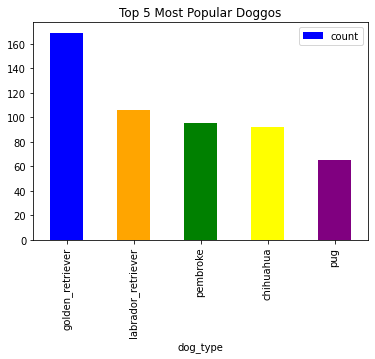

In [93]:
# plot results in bar graph
my_colors=['blue','orange', 'green', 'yellow', 'purple']
df2.plot(kind='bar', x='dog_type', y='count', color=my_colors, title='Top 5 Most Popular Doggos');

**Are Puppers the best rated Dogs?**

According to [DoggoLingo](https://en.wikipedia.org/wiki/DoggoLingo#:~:text=An%20affectionate%20way%20of%20saying,woofer%2C%20floofer%20or%20boofer) a doggo is an affectionate term for any dog. Since my analysis includes all dogs, I will not include the 'doggo' column but keep it focused to 'puppo', 'pupper', and 'floofer':

pupper - puppy

floofer - very big dog

puppo - very small dog

I will analyze to see if puppers are the highest rated doggo.

**NOTE:** there seems to be two different definitions on what a 'puppo' is. I am going to use the FIRST definition in [Urban Dictionary](https://www.urbandictionary.com/define.php?term=Puppo) meaning of a small dog(puppo) and puppy(pupper) for one analysis and then take 'puppo'+'pupper'/2 for another analysis using the second definition in Urban Dictionary.

**ALSO NOT:** not all tweets indicated the type of dog, so the doggo column is not included in the analysis.



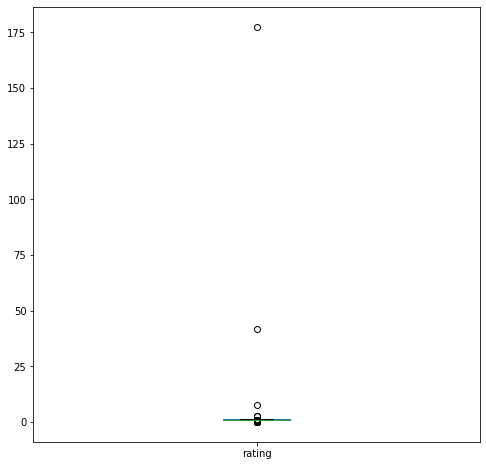

In [94]:
# get 'doggo', 'floofer', 'pupper', 'puppo', 'favorited'
dog_fav=main[['floofer', 'pupper', 'puppo', 'rating']]
# checking for outliers for all dog ratings
dog_fav.boxplot(column=['rating'], grid=False, figsize=(8,8));

In [95]:
# checking for outliers for all dog ratings
mean=dog_fav['rating'].mean()
sd=dog_fav['rating'].std()
(mean, sd)

(1.1700196270853778, 4.022546801268097)

In [96]:
# choose 4 standard deviations from the mean
# remove outliers that lie more than 4 std from the mean
dog_fav= dog_fav[(dog_fav['rating']<= mean+(4*sd))] 

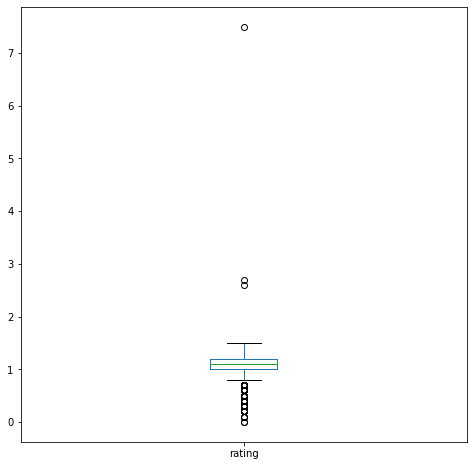

In [97]:
# view outliers again
dog_fav.boxplot(column=['rating'], grid=False, figsize=(8,8));

In [98]:
# replace the word 'None' with zeros
dog_fav=dog_fav.replace("None", 0)

In [99]:
# view new dataframe
dog_fav.sample(5)

,floofer,pupper,puppo,rating
1415,0,0,0,1.0
831,0,0,0,1.1
1816,0,0,0,1.1
1163,0,0,0,1.0
483,0,0,0,1.2


In [100]:
# create a dictionary of the means
mean_ratings= {'Floofer': [dog_fav.loc[dog_fav['floofer']=='floofer', 'rating'].mean()], 'Puppo': [dog_fav.loc[dog_fav['puppo']=='puppo', 'rating'].mean()], 'Pupper': [dog_fav.loc[dog_fav['pupper']=='pupper', 'rating'].mean()]}

In [101]:
# create a datframe of the means and plot
doggo_rating_mean=pd.DataFrame(mean_ratings)
doggo_means=doggo_rating_mean.T
doggo_means.describe()

,0
count,3.000000
mean,1.155859
std,0.069738
min,1.075909
25%,1.131705
50%,1.187500
75%,1.195833
max,1.204167


In [102]:
# Rename mean column to 'mean'
doggo_means.columns=['mean']

In [103]:
# Display Dog Type Mean Dataframe
doggo_means

,mean
Floofer,1.187500
Puppo,1.204167
Pupper,1.075909


**Puppo** dog type has the highest mean value at 1.204167 which is a bit higher than the average of all 3 at 1.155859 and sd of 0.06.

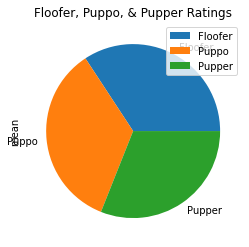

In [104]:
# view results
doggo_means.plot.pie(y='mean', title='Floofer, Puppo, & Pupper Ratings');

**Puppo** has the highest rating

Combine 'puppo' and 'pupper', mean value:

In [105]:
# average of pupper and puppo
pp_mean=(doggo_means['mean']['Puppo']+doggo_means['mean']['Pupper'])/2

**Floofer** has a higher rating when puppoand pupper types are averaged together.

In [106]:
doggo_rating_mean.insert(3, "puppo|pupper", pp_mean, True)
doggo_rating_mean[['Floofer', 'puppo|pupper']]

,Floofer,puppo|pupper
0,1.1875,1.140038


**t-test**

Are iphones the most popular source?

Recall:

**SOURCE**

1 - tweetdeck

2 - vine.co

3 - twitter.com

4 - iphone

In [123]:
# get subset of main
# notice that #2 for vine.co was removed in the cleaning process
sources=main.source.value_counts()
sources=sources.to_frame()
sources=sources.rename(index={4:'iphone', 3:'twitter.com', 1:'tweetdeck'})

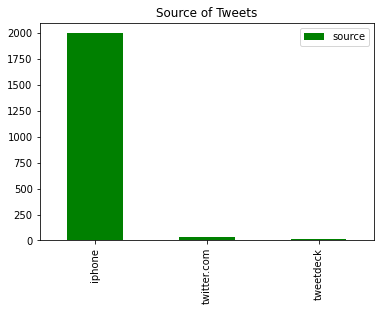

In [124]:
# plot results in bar graph
my_colors=['green', 'orange', 'purple']
sources.plot(kind='bar', color=my_colors, title='Source of Tweets');

<h2><span style="color:orange"><em>Conclusion</em></span></h2>

My assumptions starting this project:

- Retrievers are the most popular dog breed
- Puppers best the best rated dogs
- iphones are the most use source

**Are retrievers the most popular dog breed?** 

I came into this assumption with clear bias, as my childhood dog was a golden retriever, "Lady", and she was an AMAZING dog. But, I was happy to find out, according to this dataset, retrievers are indeed the most popular doggos. In fact, golden retriever came in with 169 and labrador retriever at 106 taking the two top spots. The next 3 followed with pembrok at 95,	chihuahua at 92, and pug at 65.

**Are Puppers the best rated dog type?**

